Getting the validation data and seperating it into masks and normal images

In [1]:
import os
import shutil

### Getting the files from download folder to seperate img/mask files before uploading to drive

# test_files = os.listdir("C:\\Users\\victo\\Downloads\\Test_100")
# validation_files = os.listdir("C:\\Users\\victo\\Downloads\\Validation_100")

# for file in validation_files:
#     src = "C:\\Users\\victo\\Downloads\\Validation_100\\" + file
#     if file.endswith('mask.png'):
#         shutil.copy2(src, "data\\masks\\" + file)
#     else:
#         shutil.copy2(src, "data\\imgs\\" + file)

# for file in test_files:
#     src = "C:\\Users\\victo\\Downloads\\Test_100\\" + file
#     if file.endswith('mask.png'):
#         shutil.copy2(src, "val\\masks\\" + file)
#     else:
#         shutil.copy2(src, "val\\imgs\\" + file)

!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True
print('Installation is done.')


Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.1+cu102 which is incompatible.
Installation is done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1

## Creating patches from HPF image

In [3]:
dataname="tumours"

patch_size=500 #size of the tiles to extract and save in the database, must be >= to training size
stride_size=250 #distance to skip between patches, 1 indicated pixel wise extraction, patch_size would result in non-overlapping tiles
mirror_pad_size=250 # number of pixels to pad *after* resize to image with by mirroring (edge's of patches tend not to be analyzed well, so padding allows them to appear more centered in the patch)
resize=1 #resize input images
classes=[0,1,2] #what classes we expect to have in the data,

In [4]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection
import sklearn.feature_extraction.image
import random


seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed} {sklearn.__version__}")

random seed (note down for reproducibility): 5261289464504406486 1.0.2


In [5]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

In [ ]:
files_data = os.listdir("drive/MyDrive/Colab Notebooks/Cswk 3/data/masks") # create a list of the files, in this case we're only interested in files which have masks so we can use supervised learning
files_test = os.listdir("drive/MyDrive/Colab Notebooks/Cswk 3/val/masks") # create a list of the files, in this case we're only interested in files which have masks so we can use supervised learning
print(len(files_data))
print(len(files_test))

#create training and validation stages and split the files appropriately between them
phases={}
phases['train'] = files_data
phases['val'] = files_test

#specify that we'll be saving 2 different image types to the database, an image and its associated mask
imgtypes=["img","mask"]

100
100


In [ ]:
io_test = cv2.imread("drive/MyDrive/Colab Notebooks/Cswk 3/data/masks/" + "TCGA-4P-AA8J-01Z-00-DX1.5B44796F-D099-4076-9CAF-B40C2B83F432_0_mask.png", 0)

print(io_test.shape)
print(np.unique(io_test, return_counts=True)[0])
print(np.unique(io_test, return_counts=True)[1])

## The values for white, grey and black are found here using np.unique the rest is considered noise

print(io_test[io_test == 129].size)
print(io_test[io_test == 0].size)
print(io_test[io_test == 255].size)

In [ ]:
### Checking the shape of the input images they are (4500,4500), (2250,2250) or (1000,1000)

phase = 'train'

dir_imgs = "drive/MyDrive/Colab Notebooks/Cswk 3/data/imgs/" if phase == 'train' else "drive/MyDrive/Colab Notebooks/Cswk 3/val/imgs/"
dir_masks = "drive/MyDrive/Colab Notebooks/Cswk 3/data/masks/" if phase == 'train' else "drive/MyDrive/Colab Notebooks/Cswk 3/val/masks/"

for i, file in enumerate(phases[phase]):
    for imgtype in imgtypes:
        if imgtype == "img":
            io = cv2.cvtColor(cv2.imread(dir_imgs + file.replace("_mask.png",".png")),cv2.COLOR_BGR2RGB)
        else:
            io = cv2.imread(dir_masks + file, 0)
    
    print(i+1, io.shape)


1 (4500, 4500)
2 (4500, 4500)
3 (4500, 4500)
4 (4500, 4500)
5 (4500, 4500)
6 (4500, 4500)
7 (4500, 4500)
8 (4500, 4500)
9 (4500, 4500)
10 (4500, 4500)
11 (4500, 4500)
12 (4500, 4500)
13 (4500, 4500)
14 (4500, 4500)
15 (2250, 2250)
16 (4500, 4500)
17 (4500, 4500)
18 (4500, 4500)
19 (4500, 4500)
20 (4500, 4500)
21 (4500, 4500)
22 (4500, 4500)
23 (1000, 1000)
24 (4500, 4500)
25 (4500, 4500)
26 (4500, 4500)
27 (4500, 4500)
28 (2250, 2250)
29 (1000, 1000)
30 (4500, 4500)
31 (4500, 4500)
32 (4500, 4500)
33 (4500, 4500)
34 (4500, 4500)
35 (4500, 4500)
36 (1000, 1000)
37 (4500, 4500)
38 (4500, 4500)
39 (4500, 4500)
40 (4500, 4500)
41 (4500, 4500)
42 (4500, 4500)
43 (4500, 4500)
44 (4500, 4500)
45 (4500, 4500)
46 (4500, 4500)
47 (4500, 4500)
48 (4500, 4500)
49 (4500, 4500)
50 (4500, 4500)
51 (4500, 4500)
52 (4500, 4500)
53 (4500, 4500)
54 (4500, 4500)
55 (4500, 4500)
56 (4500, 4500)
57 (4500, 4500)
58 (4500, 4500)
59 (4500, 4500)
60 (4500, 4500)
61 (4500, 4500)
62 (4500, 4500)
63 (4500, 4500)
6

In [ ]:
storage={} #holder for future pytables

block_shape={} #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d
block_shape["img"]= np.array((patch_size,patch_size,3))
block_shape["mask"]= np.array((patch_size,patch_size)) 

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print('Phase: {}'.format(phase))

    dir_imgs = "drive/MyDrive/Colab Notebooks/Cswk 3/data/imgs/" if phase == 'train' else "drive/MyDrive/Colab Notebooks/Cswk 3/val/imgs/"
    dir_masks = "drive/MyDrive/Colab Notebooks/Cswk 3/data/masks/" if phase == 'train' else "drive/MyDrive/Colab Notebooks/Cswk 3/val/masks/"
    
    totals=np.zeros((2,len(classes))) # we can to keep counts of all the classes in for in particular training, since we 
    totals[0,:]=classes               # can later use this information to create better weights

    hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) #create the array for storage
    
    for imgtype in imgtypes: #for each of the image types, in this case mask and image, we need to create the associated earray
        storage[imgtype]= hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,  
                                                  shape=np.append([0],block_shape[imgtype]), 
                                                  chunkshape=np.append([1],block_shape[imgtype]),
                                                  filters=filters)

    count = 1
    for file in phases[phase]: #now for each of the files
        print('{}. Filename: {}'.format(count, file))
        count += 1
        
        for imgtype in imgtypes:
            if imgtype == "img": #if we're looking at an img, it must be 3 channel, but cv2 won't load it in the correct channel order, so we need to fix that
                print('Image')
                io = cv2.cvtColor(cv2.imread(dir_imgs + file.replace("_mask.png",".png")),cv2.COLOR_BGR2RGB)
                interp_method = PIL.Image.BICUBIC
                
            else: #if its a mask image, then we only need a single channel (since grayscale 3D images are equal in all channels)
                print('Mask')
                io = cv2.imread(dir_masks + file, 0)  # gets the greyscale of the image
                interp_method = PIL.Image.NEAREST #want to use nearest! otherwise resizing may cause non-existing classes to be produced via interpolation (e.g., ".25")

                ### Change grayscale values to 0, 1 or 2 which is black, gray, white (background, normal, tumour)
                # gray 129 is grey
                io[io == 255] = 2 # white
                io[io == 129] = 1 # gray
                io[io > 2] = 0 # black
                
                for i,key in enumerate(classes): #sum the number of pixels, this is done pre-resize, the but proportions don't change which is really what we're after
                    totals[1,i] += sum(sum(io==key))

            print("Image Shape: {}".format(io.shape))

            mirror_pad_size = int((5000 - io.shape[0])/2) # dynamically adjusts padding so every image has size 5000

            io = cv2.resize(io, (0,0), fx=resize, fy=resize, interpolation=interp_method) #resize it as specified above

            # checks if img or mask as img is 3d and mask is 2d so padding is different

            if imgtype == "img":
                io = np.pad(io, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
            else:
                io = np.pad(io, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size)], mode="reflect")
            print("Image Shape: {}".format(io.shape))

            # extract small patches out of these big ROIs/HPFs
            io_arr_out = []
            for i in range(0, io.shape[0], patch_size):
              for j in range(0, io.shape[1], patch_size):
                patch = io[i:i+patch_size, j:j+patch_size,...]
                patchArr = np.array(patch, dtype=type(patch))
                io_arr_out.append(patch)
            
            io_arr_out = np.array(io_arr_out, dtype=type(io_arr_out))
            # print('Output Array Shape: {}'.format(io_arr_out.shape))
          
            #save the 4D tensor to the table
            storage[imgtype].append(io_arr_out) 

        storage["filename"].append([file for _ in range(io_arr_out.shape[0])]) #add the filename to the storage array
        
    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

Phase: train
1. Filename: TCGA-BB-A6UO-01Z-00-DX1.11D049DC-EFC3-47EB-B390-A694BFD304A2_1_mask.png
Image
Image Shape: (4500, 4500, 3)
Image Shape: (5000, 5000, 3)
Mask
Image Shape: (4500, 4500)
Image Shape: (5000, 5000)
2. Filename: TCGA-BB-A6UO-01Z-00-DX1.11D049DC-EFC3-47EB-B390-A694BFD304A2_0_mask.png
Image
Image Shape: (4500, 4500, 3)
Image Shape: (5000, 5000, 3)
Mask
Image Shape: (4500, 4500)
Image Shape: (5000, 5000)
3. Filename: TCGA-C9-A47Z-01Z-00-DX1.7999EE26-CB1A-464D-8E88-F3122F8D1A41_1_mask.png
Image
Image Shape: (4500, 4500, 3)
Image Shape: (5000, 5000, 3)
Mask
Image Shape: (4500, 4500)
Image Shape: (5000, 5000)
4. Filename: TCGA-BB-A6UM-01Z-00-DX1.403D4D0A-83F4-4D2F-9CBB-C7A1470AC565_1_mask.png
Image
Image Shape: (4500, 4500, 3)
Image Shape: (5000, 5000, 3)
Mask
Image Shape: (4500, 4500)
Image Shape: (5000, 5000)
5. Filename: TCGA-BB-8601-01Z-00-DX1.A226FE85-28D7-44C1-8330-CC687677EC59_0_mask.png
Image
Image Shape: (4500, 4500, 3)
Image Shape: (5000, 5000, 3)
Mask
Image Sha

## Training UNET

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import tables
import os
import sys
import glob
import PIL
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import model_selection
import sklearn.feature_extraction.image
import random
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet
import scipy.ndimage 
import time
import math
import tables
import random
from sklearn.metrics import confusion_matrix
from skimage import io, morphology

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 6639285530127238629


In [7]:
ON_GPU = True

gpuid = 0

# --- unet params
# these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes = 3    #number of classes in the data mask that we'll aim to predict
in_channels = 3  #input channel of the data, RGB = 3
padding = True   #should levels be padded
depth = 5      # depth of the network -- default of 5 for unet

wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 64
patch_size = 64 # rezises the patches to 64 x 64 this is a large compression but required for training to not take too long
num_epochs = 10
edge_weight = 1.1 # edges tend to be the most poorly segmented given how little area they 
                  # occupy in the training set, this paramter boosts their values along the lines of the original UNET paper

phases = ["train","val"] # how many phases did we create databases for
validation_phases= ["val"]

ignore_index = -100

In [8]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')
    
print(device)

cpu


In [9]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, 
             in_channels=in_channels, 
             padding=padding,depth=depth,
             wf=wf, up_mode=up_mode, 
             batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	122471


In [10]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
        
    def __getitem__(self, index):
        # opening should be done in __init__ but seems to be
        # an issue with multithreading so doing here
        with tables.open_file(self.fname,'r') as db:
            self.img=db.root.img
            self.mask=db.root.mask
       
            #get the requested image and mask from the pytable
            img = self.img[index,:,:,:]
            mask = self.mask[index,:,:]

        # the original Unet paper assignes increased weights to the edges of the annotated objects
        # their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        # highlight all the pixels which were "added"
        if(self.edge_weight):
            # weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
            weight = scipy.ndimage.binary_dilation(mask==1, iterations =2) & ~mask
        else: # otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) # in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) # inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new =mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()

            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()


        return img_new,  np.array(mask_new),  np.array(weight_new)
    def __len__(self):
        return self.nitems

In [12]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize(patch_size),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(patch_size),
    ])


dataset={}
dataLoader={}
print(phases)
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    print(phase)
    dataset[phase] = Dataset(f"{dataname}_{phase}.pytable", 
                             img_transform=img_transform, 
                             mask_transform = mask_transform,
                             edge_weight=edge_weight)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 
    
    print(f'{phase} Dataset completed')

['train', 'val']
train
train Dataset completed
val
val Dataset completed


torch.Size([3, 64, 64]) (64, 64) (64, 64)


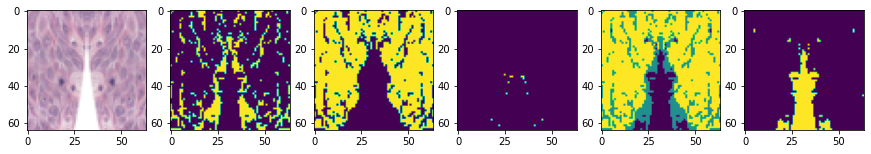

In [ ]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["val"][5]

print(img.shape, patch_mask.shape, patch_mask_weight.shape)
fig, ax = plt.subplots(1,6, figsize=(15,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==1)
ax[2].imshow(patch_mask==2)
ax[3].imshow(patch_mask_weight)
ax[4].imshow(patch_mask)
ax[5].imshow(patch_mask==0)

In [ ]:
optim = torch.optim.Adam(model.parameters()) # Adam is going to be the most robust

In [ ]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
print(nclasses)
print(dataset["train"].numpixels.shape)
print(dataset["train"].numpixels)

class_weight = dataset["train"].numpixels[1,0:3] #don't take ignored class into account here
print(class_weight)
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) # show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index, reduce=False)
               # reduce = False makes sure we get a 2D output instead of a 1D "summary" value

3
(2, 3)
[[0.00000000e+00 1.00000000e+00 2.00000000e+00]
 [5.84057840e+08 5.80976483e+08 7.11090677e+08]]
[5.84057840e+08 5.80976483e+08 7.11090677e+08]
tensor([0.6887, 0.6903, 0.6210])


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
best_loss_on_test = np.Infinity
edge_weight = torch.tensor(edge_weight).to(device)
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((3,3)) for key in phases}

    for phase in phases: #iterate through both training and validation states
        #print(phase)
        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        # print(len(dataLoader[phase]))
        for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
            #print("Batch Number: {}".format(ii+1))
            
            X = X.to(device)  # [Nbatch, 3, H, W]
            y_weight = y_weight.type('torch.FloatTensor').to(device)
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

            with torch.set_grad_enabled(phase == 'train'): 
                          # dynamically set gradient computation, in case of validation, this isn't needed
                          # disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1

                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()


    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' \
              % (timeSince(start_time, (epoch+1) / num_epochs), 
              epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


        torch.save(state, f"{dataname}_unet_best_model.pth") # saves to current working directory
    else:
        print("")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


11m 31s (- 103m 42s) ([1/10] 10%), train loss: 0.4435 test loss: 0.4106  **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


22m 52s (- 91m 29s) ([2/10] 20%), train loss: 0.3311 test loss: 0.3448  **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


34m 18s (- 80m 2s) ([3/10] 30%), train loss: 0.2932 test loss: 0.3595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


45m 47s (- 68m 40s) ([4/10] 40%), train loss: 0.2700 test loss: 0.2858  **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


57m 8s (- 57m 8s) ([5/10] 50%), train loss: 0.2568 test loss: 0.3522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


69m 0s (- 45m 59s) ([6/10] 60%), train loss: 0.2464 test loss: 0.2915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


80m 24s (- 34m 27s) ([7/10] 70%), train loss: 0.2414 test loss: 0.2775  **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


91m 42s (- 22m 55s) ([8/10] 80%), train loss: 0.2336 test loss: 0.2800


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


103m 2s (- 11m 26s) ([9/10] 90%), train loss: 0.2307 test loss: 0.2805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


114m 47s (- -1m 59s) ([10/10] 100%), train loss: 0.2260 test loss: 0.2871


In [13]:
checkpoint = torch.load(f"{dataname}_unet_best_model.pth") # load best model from current working directory
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

### Accuracy of Segmentation

In [14]:
# code to calculate dice index

def dice_coef(y_true, y_pred, index):
    intersection = np.sum((y_true == index) == (y_pred == index))
    return (2. * intersection) / (y_true.size + y_pred.size)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true, y_pred, index)
    return dice/numLabels # taking average

In [15]:
batch_size = 1 # nicer to have a single batch so that we can iterately 
               # view the output, while not consuming too much 
edge_weight = 1

phase="val"

In [16]:
# note that since we need the transofrmations to be reproducible for both masks and images
# we do the spatial transformations first, and afterwards do any color augmentations

# in the case of using this for output generation, we want to use the original 
# images since they will give a better sense of the exepected 
# output when used on the rest of the dataset, as a result, we disable all unnecessary augmentation.
# the only component that remains here is the randomcrop, to ensure that regardless of the size of the image
# in the database, we extract an appropriately sized patch
img_transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize(patch_size),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(patch_size),
    ])

dataset={}
dataLoader={}
    
dataset[phase]=Dataset( f"{dataname}_{phase}.pytable", # load from working directory
                        img_transform=img_transform, 
                        mask_transform = mask_transform,
                        edge_weight=edge_weight)
dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) #,pin_memory=True)

In [ ]:
model.eval()   # Set model to evaluate mode
dicey = []

### calculate dice coefficient for each image using best model then we average the results

for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
    
    X = X.to(device)  # [Nbatch, 3, H, W]
    y_weight = y_weight.type('torch.FloatTensor').to(device)
    y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

    prediction = model(X)  # [N, Nclass, H, W]

    p = prediction[:,:,:,:].detach().cpu().numpy()
    cpredflat = np.argmax(p, axis=1).flatten()
    yflat = y.cpu().numpy().flatten()


    dicey.append(dice_coef_multilabel(yflat, cpredflat, 3))

print(np.array(dicey).mean())

0.87451259765625


Mean Dice Coefficient: 0.87451259765625 +-(0.13593935756177516)
Minimum dice coefficient: 0.3333


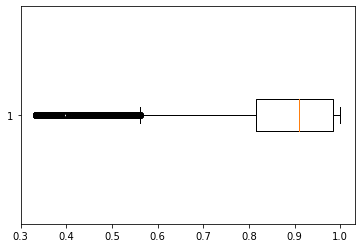

In [ ]:
### plot box plot of dice coefficients for each image

dicey = np.array(dicey)
print("Mean Dice Coefficient: {} +-({})".format(dicey.mean(), np.std(dicey)))

print("Minimum dice coefficient: {}".format(round(np.min(dicey), 4)))

plt.boxplot(dicey, vert=False)
plt.show()

### Visualize results

In [ ]:
# Get the worst segmented image
worst_index = np.argmin(dicey)
(w_img, w_patch_mask, w_patch_mask_weight) = dataset[phase][worst_index]

# Get the best segmented image
best_index = np.argmax(dicey)
(b_img, b_patch_mask, b_patch_mask_weight) = dataset[phase][best_index]

#generate its output
w_output=model(w_img[np.newaxis,...].to(device))
w_output=w_output.detach().squeeze().cpu().numpy()
w_output=np.moveaxis(w_output,0,-1) 

b_output=model(b_img[np.newaxis,...].to(device))
b_output=b_output.detach().squeeze().cpu().numpy()
b_output=np.moveaxis(b_output,0,-1) 


#visualize its result
fig, ax = plt.subplots(1,3, figsize=(10,4))  # 1 row, 3 columns


print(dicey[worst_index])
ax[0].imshow(np.argmax(w_output,axis=-1))
ax[1].imshow(w_patch_mask)
ax[2].imshow(np.moveaxis(w_img.numpy(),0,-1))

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4))  # 1 row, 2 columns

print(dicey[best_index])
ax[0].imshow(np.argmax(b_output,axis=-1))
ax[1].imshow(b_patch_mask)
ax[2].imshow(np.moveaxis(b_img.numpy(),0,-1))

# Task 2


In [17]:
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [18]:
# imports required for the tasks
import openslide as ops # for WSI handling
from skimage.filters.rank import entropy # for image manipulation
from skimage.morphology import disk
from skimage import measure
import numpy as np # for normal computation
import matplotlib.pyplot as plt # for visualization 

Get 5 HPFs from each WSI by picking random 512 x 512 points with a high enough unique pixel count.


In [ ]:
neg_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg")
print(neg_files)

for i, file in enumerate(neg_files):
    wsi_obj = ops.OpenSlide('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg/' + file)
    magnification = wsi_obj.properties['openslide.objective-power']
    desired_level = 2 if magnification == '40' else 1

    dimensions = wsi_obj.level_dimensions[desired_level]
    count = 0

    while count < 5:
        region = (np.random.choice(range(dimensions[0] - 512)), np.random.choice(range(dimensions[1] - 512)))
        hpf = wsi_obj.read_region(region, desired_level, (512, 512)).convert('RGB')
        opencvImage = cv2.cvtColor(np.array(hpf), cv2.COLOR_RGB2BGR)

        # f, ax = plt.subplots(1, 1, figsize = (5, 5))

        if np.unique(opencvImage).size > 100:
            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_' + str(i+1) + '_' + str(count+1) + '.png', opencvImage)
            count += 1

['TCGA-BB-4224-01Z-00-DX1.ebdb44ef-4266-40b7-bc1b-e197c9813868.svs', 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4.svs', 'TCGA-CN-6012-01Z-00-DX1.bd9283bb-47c7-41ab-996a-f3f5070cfc73.svs', 'TCGA-D6-6823-01Z-00-DX1.7291f093-209b-4e88-8ceb-842f7c5707c0.svs', 'TCGA-D6-6826-01Z-00-DX1.9346b65d-ffc0-46ed-b68b-e18b2a43c5ea.svs']


In [ ]:
pos_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos")

print(pos_files)

for i, file in enumerate(pos_files):
    wsi_obj = ops.OpenSlide('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos/' + file)
    magnification = wsi_obj.properties['openslide.objective-power']
    desired_level = 2 if magnification == '40' else 1

    dimensions = wsi_obj.level_dimensions[desired_level]
    count = 0

    while count < 5:
        # print(dimensions)
        region = (np.random.choice(range(dimensions[0] - 512)), np.random.choice(range(dimensions[1] - 512)))
        hpf = wsi_obj.read_region(region, desired_level, (512, 512)).convert('RGB')
        opencvImage = cv2.cvtColor(np.array(hpf), cv2.COLOR_RGB2BGR)

        # f, ax = plt.subplots(1, 1, figsize = (5, 5))

        if np.unique(opencvImage).size > 100:
            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_' + str(i+1) + '_' + str(count+1) + '.png', opencvImage)
            count += 1

['TCGA-BA-5153-01Z-00-DX1.045011D8-DF25-4B13-BF92-188D5EBE96CF.svs', 'TCGA-BB-4223-01Z-00-DX1.8806b83e-910f-4ee8-aa83-f84e3d13155f.svs', 'TCGA-BB-7861-01Z-00-DX1.efdd186f-1bbf-4e43-9875-9458cebcd0dd.svs', 'TCGA-BB-7864-01Z-00-DX1.a8e9cdba-2026-4290-8e49-36086b65e806.svs', 'TCGA-HD-7832-01Z-00-DX1.2240D7A6-AF1F-43F9-9748-05498FEECAD5.svs']


Get tiatoolbox running for inference on tiles

In [19]:
from tiatoolbox.models.engine.semantic_segmentor import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import WSIReader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

In [20]:
def infer_batch(model, batch_data, on_gpu):
        """Run inference on an input batch.
        This contains logic for forward operation as well as
        i/o aggregation.
        Args:
            model (nn.Module): PyTorch defined model.
            batch_data (ndarray): A batch of data generated by
              torch.utils.data.DataLoader.
            on_gpu (bool): Whether to run inference on a GPU.
        Returns:
            List of network output head, each output is a `ndarray`.
        """
        model.eval()

        imgs = batch_data
        imgs = imgs.to("cpu").type(torch.float32)

        with torch.inference_mode():
            logits = model(imgs)
            logits = logits.permute(0, 2, 3, 1) # as your output is channels first so swap them

        logits = logits.detach().squeeze().cpu().numpy()
        return [logits]

In [21]:
def preproc(image):
        """Define the pre-processing of this class of model."""
        # as before sending the patches we process them through the transforms
        # which will transform it and normalize it 
        return img_transform(image)

In [22]:
# adding the above function to our model as TIAToolbox will be looking for these
model.preproc_func = preproc
model.infer_batch = infer_batch

In [23]:
# Tile prediction of neg HPV files
neg_hpf_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF")
img_files_neg = ["/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/" + img for img in neg_hpf_files]

print(img_files_neg)


bcc_segmentor = SemanticSegmentor(
    model=model,
    num_loader_workers=4, batch_size=4,
)

output_neg = bcc_segmentor.predict(
        img_files_neg,
        save_dir="neg_results/",
        mode="tile",
        resolution=1.0,
        units="baseline",
        patch_input_shape=[patch_size, patch_size],
        patch_output_shape=[patch_size, patch_size],
        stride_shape=[patch_size, patch_size],
        on_gpu=False,
        crash_on_exception=True,
    )

|2022-03-16|13:02:31.233| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/semantic_segmentor.py:1027: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "



['/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_1.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_3.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_2_5.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_2_1.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_4.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_2_3.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_5.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_3_1.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_2_4.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_2_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_3_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_3_3.png', '/content/drive/MyDrive/

|2022-03-16|13:02:31.343| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/semantic_segmentor.py:275: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "

|2022-03-16|13:02:31.359| [WARNING] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

|2022-03-16|13:02:31.655| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2022-03-16|13:02:31.657| [WARNIN

Raw prediction dimensions: (512, 512, 3)


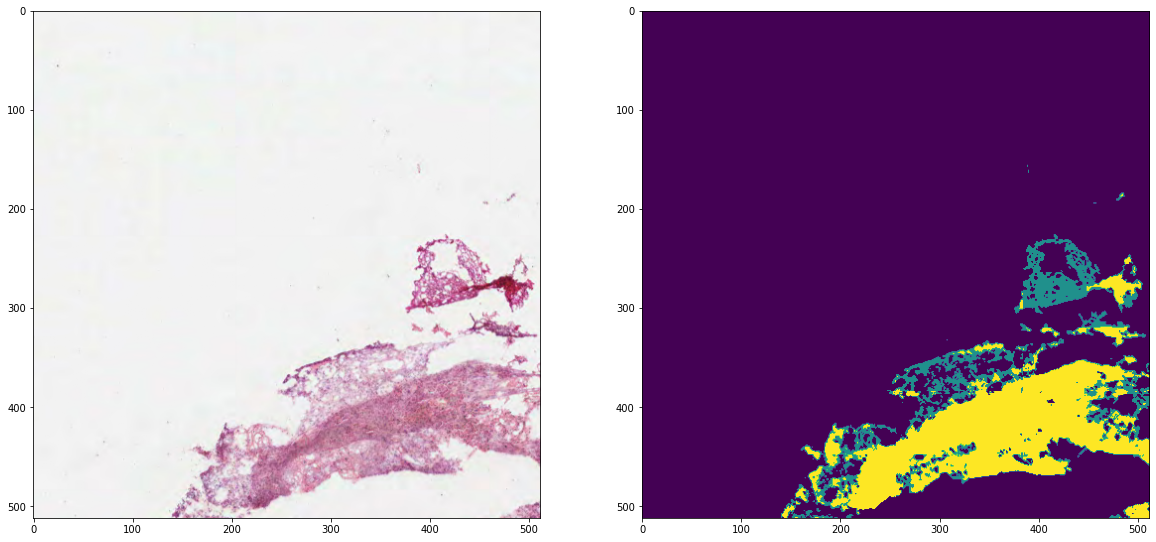

In [24]:
from matplotlib import cm
from tiatoolbox.utils.visualization import overlay_prediction_mask

wsi_prediction_raw = np.load(output_neg[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(wsi_prediction_raw.shape))

fig, ax = plt.subplots(1,2, figsize=(20,10))  # 1 row, 2 columns

ax[0].imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_neg_HPF/image_1_1.png'))
ax[1].imshow(np.argmax(wsi_prediction_raw,axis=-1))

In [25]:
# Tile prediction of pos HPV files
pos_hpf_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF")
img_files_pos = ["/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/" + img for img in pos_hpf_files]

print(img_files_pos)


bcc_segmentor = SemanticSegmentor(
    model=model,
    num_loader_workers=4, batch_size=4,
)

output_pos = bcc_segmentor.predict(
        img_files_pos,
        save_dir="pos_results/",
        mode="tile",
        resolution=1.0,
        units="baseline",
        patch_input_shape=[patch_size, patch_size],
        patch_output_shape=[patch_size, patch_size],
        stride_shape=[patch_size, patch_size],
        on_gpu=False,
        crash_on_exception=True,
    )

|2022-03-16|13:02:56.915| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/semantic_segmentor.py:1027: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "



['/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_1.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_3.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_4.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_5.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_2_1.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_2_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_2_4.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_2_5.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_2_3.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_3_2.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_3_4.png', '/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_3_3.png', '/content/drive/MyDrive/

|2022-03-16|13:02:56.967| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/semantic_segmentor.py:275: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "

|2022-03-16|13:02:56.979| [WARNING] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

|2022-03-16|13:02:57.358| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2022-03-16|13:02:57.360| [WARNIN

Raw prediction dimensions: (512, 512, 3)


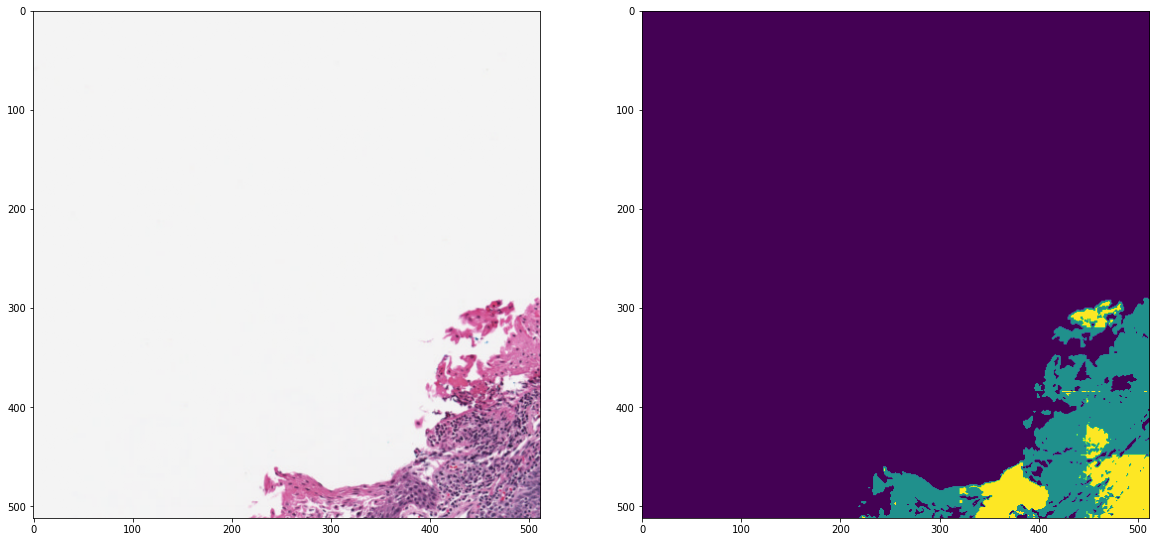

In [26]:
from matplotlib import cm
from tiatoolbox.utils.visualization import overlay_prediction_mask

wsi_prediction_raw = np.load(output_pos[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(wsi_prediction_raw.shape))

fig, ax = plt.subplots(1,2, figsize=(20,10))  # 1 row, 2 columns

ax[0].imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/Cswk 3/HPV_pos_HPF/image_1_1.png'))
ax[1].imshow(np.argmax(wsi_prediction_raw,axis=-1))

# Task 3

Get ratio of tumorous to non tumorous areas first.

In [36]:
## Positive HPV Results

pos_area_ratios = []
for i in range(5):
  i = i*5
  tumour_area = 0
  nontumor_area = 0
  for j in range(5):
    wsi_prediction_raw = np.load(output_pos[i+j][1]+'.raw.0.npy')
    # print(np.unique(np.argmax(wsi_prediction_raw,axis=-1), return_counts=True))
    try:
      nontumor_area += np.unique(np.argmax(wsi_prediction_raw,axis=-1), return_counts=True)[1][1]
    except IndexError:
      nontumor_area += 0
    try:
      tumour_area += np.unique(np.argmax(wsi_prediction_raw,axis=-1), return_counts=True)[1][2]
    except IndexError:
      tumour_area += 0
  pos_area_ratios.append((tumour_area / nontumor_area))

print(pos_area_ratios)

## Negative HPV Results

neg_area_ratios = []
for i in range(5):
  i = i*5
  tumour_area = 0
  nontumor_area = 0
  for j in range(5):
    wsi_prediction_raw = np.load(output_neg[i+j][1]+'.raw.0.npy')
    try:
      nontumor_area += np.unique(np.argmax(wsi_prediction_raw,axis=-1), return_counts=True)[1][1]
    except IndexError:
      nontumor_area += 0
    try:
      tumour_area += np.unique(np.argmax(wsi_prediction_raw,axis=-1), return_counts=True)[1][2]
    except IndexError:
      tumour_area += 0
  neg_area_ratios.append((tumour_area / nontumor_area))

print(neg_area_ratios)


[0.5357698066780479, 2.0201055466661364, 1.8723099658261753, 21.686332350049163, 0.584051724137931]
[6.8192285925732445, 3.928344987637842, 3.399866206605169, 0.35651501300893046, 0.4124003278932856]


In [123]:
pos_connected_ratios = [
                        [(4,3), (5,2), (2,1), (3,2), (5,2)], 
                        [(5,2), (5,1), (6,2), (4,2), (4,5)],
                        [(3,1), (3,10), (2,1), (1,1), (2,3)],
                        [(2,3), (3,4), (3,2), (2,3), (3,3)],
                        [(3,3), (4,4), (3,3), (4,4), (4,4)] 
                        ]

neg_connected_ratios = [
                        [(4,5), (4,4), (1,6), (1,3), (1,8)],
                        [(1,3), (1,3), (5,4), (1,3), (1,3)],
                        [(1,5), (3,1), (2,2), (5,2), (4,2)],
                        [(6,2), (5,1), (6,1), (3,1), (2,1)],
                        [(3,1), (4,1), (3,3), (1,1), (1,2)]
                       ]

RCTN_pos = np.zeros(5)
AVCT_pos = np.zeros(5)

for i, lst in enumerate(pos_connected_ratios):
  tumour = 0
  non_tumour = 0
  for j, ratio in enumerate(lst):
    tumour += ratio[0]
    non_tumour += ratio[1]
  RCTN_pos[i] = tumour / non_tumour
  AVCT_pos[i] = tumour / 5

RCTN_neg = np.zeros(5)
AVCT_neg = np.zeros(5)

for i, lst in enumerate(neg_connected_ratios):
  tumour = 0
  non_tumour = 0
  for j, ratio in enumerate(lst):
    tumour += ratio[0]
    non_tumour += ratio[1]
  RCTN_neg[i] = tumour / non_tumour
  AVCT_neg[i] = tumour / 5
  

In [124]:
print(RCTN_pos)
print(RCTN_neg)

print(AVCT_pos)
print(AVCT_neg)

[1.9        2.         0.6875     0.86666667 1.        ]
[0.42307692 0.5625     1.25       3.66666667 1.5       ]
[3.8 4.8 2.2 2.6 3.6]
[2.2 1.8 3.  4.4 2.4]


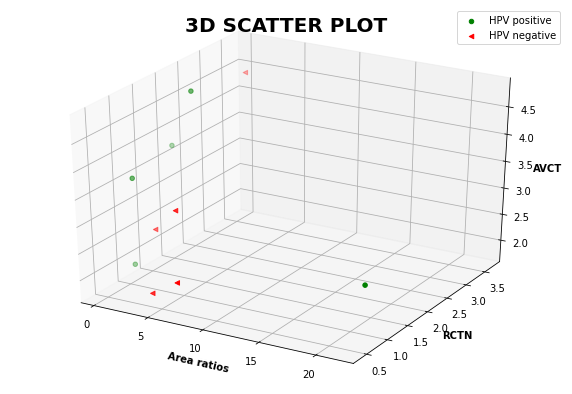

In [132]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(pos_area_ratios, RCTN_pos, AVCT_pos, marker='o', color='green', label='HPV positive')
ax.scatter3D(neg_area_ratios, RCTN_neg, AVCT_neg, marker='<', color='red', label='HPV negative')

ax.set_xlabel('Area ratios', fontweight ='bold')
ax.set_ylabel('RCTN', fontweight ='bold')
ax.set_zlabel('AVCT', fontweight ='bold')

ax.legend(loc=1)

plt.title('3D SCATTER PLOT', fontweight='bold', size=20)

plt.show()